# Occlusion Detection

Given are two aerial images (IMG1.png, IMG2.png) of an airport parking bay. These images were captured using two cameras placed at different locations and at different instants of time but overlooking the same area. It is known that the images are related by an in-plane rotation and translation.
The following point correspondences are given:

|Correspondence|IMG1 (x; y)|IMG2 (x; y)|
|--------------|-----------|-----------|
|1             |(29; 124)  | (93; 248) |
|2             |(157; 372) | (328; 399)|

Determine the changes in IMG2 with respect to IMG1.

Reading and displaying Images using matplotlib

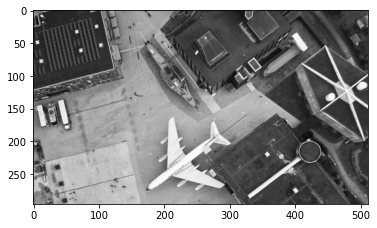

In [1]:
# importing matplotlib modules to read and plot images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read image1
img_01 = mpimg.imread('IMG1.png')

# display image1
plt.imshow(img_01,'gray')

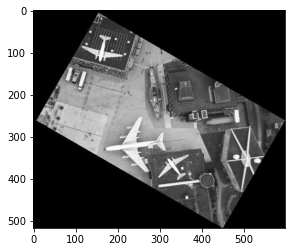

In [2]:
# importing matplotlib modules to read and plot images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read image1
img_02 = mpimg.imread('IMG2.png')

# display image1
plt.imshow(img_02,'gray')

# Bilinear nterpolation

To perform target to source mapping first we need to define a bilinear interpolation function to find intensity values of target images when they are not mapped to integer pixel co-ordinates. If the target pixel co-ordinates doesnt lie within the boundary of source image co-ordinates then the intensity value will be 0, so to do this we will parse the zero padded source image to this function. To find the intensity value at target image co-ordinates we use the following equation and if the co-ordinates are out of bound from source co-ordinates the the intensity value will be 0.

Intensity value at $(x_t,y_t)$ will be:
\begin{equation}
    I_t(x,y) = (1-a)(1-b)I_s(x_s',y_s') + (1-a)(b)I_s(x_s',y_s'+1) +  (a)(1-b)I_s(x_s'+1,y_s') +  (a)(b)I_s(x_s'+1,y_s'+1)
\end{equation}

 $ a=x_s-x_s' $, $ b=y_s-y_s' $

In [3]:
import numpy as np #numpy module is imported to handle array form of images
import math #to perform mathematical calculations
def bilinearInterpolation(image, xs, ys): 
    '''the passed image here is a zero padded image so we need to add 1 to each co-ordinate so that 
        the bilinear interpolation is performed on source image'''
    xs, ys = xs+1, ys+1
    x1, y1 = math.floor(xs), math.floor(ys) #finding the nearest integer pixel co-ordinates i.e xs',ys' as per above equation
    x_s,y_s = np.shape(image) #finding the dimensions of zero-padded source image
    x_s,y_s=x_s-2,y_s-2 #getting the dimensions of original image
    a = xs-x1
    b = ys-y1
    '''if x1,y1 lies within the source image co-ordinates then perform bilinear interpolation and 
        find the intensity value of the target image else the intensity value will be 0'''
    if x1 >= 0 and x1 <= x_s and y1 >= 0 and y1 <= y_s:
        I_t = ((1-a)*(1-b)*image[x1, y1])+ ((1-a)*b*image[x1, y1+1]) + (a*(1-b)*image[x1+1, y1])+(a*b*image[x1+1, y1+1])
    else:
        I_t = 0

    return I_t

# Homography

To perform occlusion detection we need to compute homography matrix(H), as it is said that the images are related by an in-plane translation and rotation the matrix H will be of form 
\begin{equation}
H = \begin{matrix}
    \left( \begin{array}{cc}
        \cos\theta & -\sin\theta & t_x \\
         \sin\theta & \cos\theta & t_y \\
          0 &  0 & 1
        \end{array} \right) 
        \end{matrix} 
\end{equation}
        
So here we have 3 unknowns, $\theta,t_x,t_y$ but it is generally said that H is defined only upto a scale factor the matrix H can be written as
\begin{equation}
\tag{1} 
H = \begin{matrix}
    \left( \begin{array}{cc}
        kcos\theta & -ksin\theta & kt_x \\
         ksin\theta & kcos\theta & kt_y \\    
          0 &  0 & k
        \end{array} \right) 
        \end{matrix} 
 \end{equation}                            
 So now we have 4 unknowns $\theta,t_x,t_y,k$ and we have two point correspondences which will be sufficient to compute our H matrix. 
A general H matrix will be of form 
\begin{equation}
\tag{2}
H = \begin{matrix}
    \left( \begin{array}{cc}
        h_{1_1} & h_{1_2} & h_{1_3}\\
        h_{2_1} & h_{2_2} & h_{2_3}\\
        h_{3_1} & h_{3_2} & h_{3_3}
        \end{array} \right) 
        \end{matrix} 
\end{equation}


Here $h_{3_1}=0, h_{3_2}=0$ to find rest of elements we are going to construct a matrix using $ A\underline h = 0 $ where A here will be a 4X9 matrix and $\underline h$ is a 9x1 row vector with $ h_{i_j}'s $ as elements.
\begin{equation}
A = \begin{matrix}
    \left( \begin{array}{cc}
        -x_1 & -y_1 & -1 & 0 & 0 & 0 & x_1x_1' & x_1'y_1 & x_1'\\
        0 & 0 & 0 & -x_1 & -y_1 & -1 & x_1y_1' & y_1y_1' & y_1'\\
        -x_2 & -y_2 & -1 & 0 & 0 & 0 & x_2x_2' & x_2'y_2 & x_2'\\
        0 & 0 & 0 & -x_2 & -y_2 & -1 & x_2y_2' & y_2y_2' & y_2'\\
        \end{array} \right) 
        \end{matrix} 
\end{equation}
If we use this A matrix and $\underline h$ we will be having 4 equations and 9 unknowns which cannot be solved, so let us reduce the degree of freedom. By observing equations (1) and (2) $h_{1_1}=h_{2_2}$ , $h_{1_2}=-h_{2_1}$ and $h_{3_1}=h_{3_2}=0$ now the H matrix can be written as follows: 
\begin{equation}
\tag{3}
H = \begin{matrix}
    \left( \begin{array}{cc}
        h_{1_1} & h_{1_2} & h_{1_3}\\
        -h_{1_2} & h_{1_1} & h_{2_3}\\
         0 & 0 & h_{3_3}
        \end{array} \right) 
        \end{matrix} 
\end{equation}
 To get corresponding points of image-2 with respect to image-1, say $\underline x = (x_i,y_i,1)^T$ be homogeneous co-ordinates of image-1 and $\underline x'=(x_i',y_i',1)^T$ be homogeneous co-ordinates of image-2 then $\underline x'$=$H\underline x$ using this we get the following equations:
 \begin{equation}
 \tag{4}
  h_{1_1}x_i+h_{1_2}y_i+h_{1_3}-h_{3_3}x_i'=0
  \end{equation}
  
   \begin{equation}
   \tag{5}
    -h_{1_2}x_i+h_{1_1}y_i+h_{2_3}-h_{3_3}y_i'=0
  \end{equation}
   Using equations (4) and (5) for n-point correspondences we get A matrix as follows :
   \begin{equation}
   A = \begin{matrix}
    \left( \begin{array}{cc}
       A_1\\
       A_2\\
       .\\
       .\\
       A_n
        \end{array} \right) 
        \end{matrix} 
\end{equation}
where 
\begin{equation}
 A_i = \begin{matrix}
 \left( \begin{array}{cc}
        x_i & y_i & 1 & 0 & -x_i'\\
        y_i & -x_i & 0 & 1 & -y_i'\\
        \end{array} \right) 
        \end{matrix} 
\end{equation}
here we have two point correspondences
Now $\underline h$ will be 
\begin{equation}
\underline h = \begin{matrix}
\left( \begin{array}{cc}
       h_{1_1}\\
        h_{1_2}\\
        h_{1_3}\\
        h_{2_3}\\
        h_{3_3}
        \end{array} \right) 
        \end{matrix}
\end{equation}

To find $\underline h$ we solve $ A\underline h = \underline 0 $

Function to calculate the corresponding points of image-2 with respect to image-1 using $\underline x'$=$H\underline x$

In [4]:
def corresponding_points(H, x):
    # x will be of the form [x1, y1, 1], i.e., in homogenous coordinates.
    x_prime = np.dot(H,x) #matrix multiplication of H and x
    if x_prime[-1]!=0:
        return x_prime[0]/x_prime[-1], x_prime[1]/x_prime[-1] 
    else:
        return 0, 0

Transforming the image using H matrix and calling bilinear interpolation function for target to source mapping.

In [5]:
def transform_image(source_image, H): 
    x,y=np.shape(source_image)
    image = np.zeros((x+2, y+2)) # zero padding the image for bilinear interpolation
    image[1:-1, 1:-1] = source_image #fitting the source image into image
    target_image = np.zeros((x, y))
    for xt in range(x):
        for yt in range(y):
            vec = np.array([xt, yt, 1]) # converting into homogenous coordinates
            xs, ys = corresponding_points(H, vec) 
            val = bilinearInterpolation(image, xs, ys)
            target_image[xt, yt] = val
    return target_image

Constructing A and H matrices

In [6]:
x1,y1,x2,y2=29,124,157,372
x1_prime,y1_prime,x2_prime,y2_prime=93,248,328,399
A = np.array([[x1,y1,1,0,-x1_prime],[y1,-x1,0,1,-y1_prime],[x2,y2,1,0,-x2_prime],[y2,-x2,0,1,-y2_prime]])
# NumPy SVD gives singular values in decreasing order
u, s, v_transpose = np.linalg.svd(A)
# take the last row of v_transpose
h11, h12, h13, h23, h33 = v_transpose[-1]
# construct the appropriate 3x3 matrix
H = np.array([[h11, h12, h13], [-h12, h11, h23], [0, 0, h33]]).reshape(3,3)  

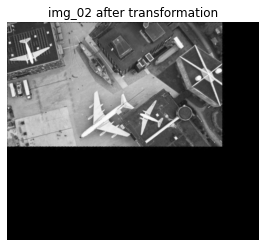

In [11]:
transformed_image_02 = transform_image(img_02, H)
plt.imshow(transformed_image_02, 'gray')
plt.title("img_02 after transformation")
plt.axis('off')
plt.show()

The transformed image contains zero pixels at the borders and hence I am cropping the transformed image to the size of that of image-1

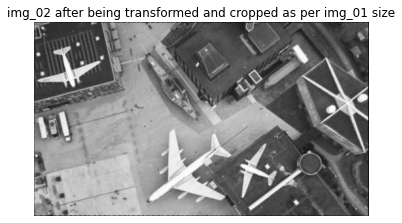

In [12]:
a, b = np.shape(img_01)
cropped_transformed_img_02 = transformed_image_02[:a, :b]
plt.imshow(cropped_transformed_img_02,'gray')
plt.title("img_02 after being transformed and cropped as per img_01 size")
plt.axis('off')
plt.show()

To detect the changes in image2 with respect to the image1 we need to calculate the difference between them.

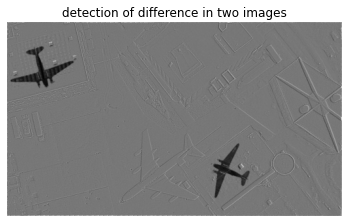

In [16]:
diff = (img_01-cropped_transformed_img_02) 
plt.imshow(diff,'gray')
plt.title("detection of difference in two images")
plt.axis('off')
plt.show()